In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import random
import pickle as pkl
import igraph as ig
import hypernetx as hnx
import xgi
import copy

# Python files
import sys
sys.path.insert(1,'../')
import simplicial as sr
import Hypergraph_Models as hm
import Hypergraph_Functions as hf
import Hypergraph_Processes as hp


# Diffusion and other functions

In [2]:
def diffusion(w,E,epsilon,slice=1,want='numbers'):
    uniform = [sum(w.values())/len(w)]*len(w)
    distance = sp.stats.wasserstein_distance(list(w.values()),uniform)
    results = {}
    if want=='numbers':
        results[0] = distance
    else:
        results[0] = w.copy()
    round = 0
    if type(epsilon) is int:
        for i in range(epsilon-1):
            chosen_edges = random.choices(E,k=slice)
            for e in chosen_edges:
                try:
                    new_weight = sum(w[v] for v in set(e))/len(set(e))
                except:
                    print('found vertex with no weight')
                    print(e)
                    print(set(e).intersection(set(w.keys())))
                for v in set(e):
                    w[v] = new_weight
            distance = sp.stats.wasserstein_distance(list(w.values()),uniform)
            round += slice
            if want=='numbers':
                results[round] = distance
            else:
                results[round] = w.copy()
    else:
        while distance>epsilon:
            chosen_edges = random.choices(E,k=slice)
            for e in chosen_edges:
                new_weight = sum(w[v] for v in set(e))/len(set(e))
                for v in set(e):
                    w[v] = new_weight
            distance = sp.stats.wasserstein_distance(list(w.values()),uniform)
            round += slice
            if want=='numbers':
                results[round] = distance
            else:
                results[round] = w.copy()
    return results

# Find best 'q' via bisection
def q_fit(E, d, m, multisets=False, skeleton=True, num_cl_samples=10, num_iterations=10):
    sr_data = sr.Simplicial(E)._simplicial_pairs()
    num_pairs = sr_data[0] + sr_data[1]
    q = 0.5
    delta = 0.5
    for i in range(num_iterations):
        delta = delta/2
        q_pairs = 0
        for j in range(num_cl_samples):
            E_q = hm.simplicial_chung_lu(d, m, q, multisets=multisets, skeleton=skeleton)
            q_data = sr.Simplicial(E_q)._simplicial_pairs()
            q_pairs += q_data[0] + q_data[1]
        q_pairs = q_pairs/num_cl_samples
        if q_pairs > num_pairs:
            q = q - delta
        else:
            q = q + delta
    return q, q_pairs

# Simple function to reorder edges by betweenness
# Smallest to largest
def reorder_by_betweenness_fast(edges):
    E = edges.copy()
    G = hnx.Hypergraph(E)
    LG = G.get_linegraph()
    g = ig.Graph.from_networkx(LG)
    bet_ig = g.betweenness()
    n = g.vcount()
    norm = 2/((n-1)*(n-2))
    betweenness = dict(zip(g.vs['_nx_name'],[x*norm for x in bet_ig])) 
    E_arranged = list(sorted(betweenness, key=betweenness.get))
    E = [E[i] for i in E_arranged]
    return E

# Getting and preparing all of the datasets

In [3]:
%%time
filenames = [
    "contact-primary-school", 
    "contact-high-school", 
    "hospital-lyon", 
    "email-enron", 
    "email-eu", 
    "diseasome", 
    "disgenenet", 
    "ndc-substances", 
    "congress-bills", 
    "tags-ask-ubuntu",
]

datasets = {}
vertex_data = {}
edge_data = {}
for filename in filenames:
    H = xgi.load_xgi_data(filename)
    E = list(set([tuple(sorted(e)) for e in H.edges.members() if len(e)<=11 and len(e)>=2])) ## changed 11 to 5
    E = [set(e) for e in E]
    V = list(set([i for e in E for i in e]))
    
    #For ask-ubuntu, we make two smaller graphs
    #One only keeps the first 20000 edges
    #The other throws away half of the vertices
    if filename == "tags-ask-ubuntu": 
        # Edge-chopped version
        V_1 = V.copy()
        E_1 = E[:20000]
        V_1,E_1 = hf.giant_component(V_1,E_1)
        datasets["ubuntu (edge-chopped)"] = (V_1,E_1)
        vertex_data["ubuntu (edge-chopped)"] = len(V_1)
        edge_data["ubuntu (edge-chopped)"] = len(E_1)

        #Vertex-chopped version
        V_2 = []
        for v in V:
            if random.choice([1,2])==1:
                V_2.append(v)
        #We use the strict definition of induced subgraph
        E_2 = []
        for e in E:
            accept = True
            for v in e:
                if v not in V_2:
                    accept = False
                    break
            if accept:
                E_2.append(e)
        V_2,E_2 = hf.giant_component(V_2,E_2)
        datasets["ubuntu (vertex-chopped)"] = (V_2,E_2)
        vertex_data["ubuntu (vertex-chopped)"] = len(V_2)
        edge_data["ubuntu (vertex-chopped)"] = len(E_2)
    # All other datasets are built the same way
    else:
        V,E = hf.giant_component(V,E)
        datasets[filename] = (V,E)
        vertex_data[filename] = len(V)
        edge_data[filename] = len(E)


CPU times: user 20.3 s, sys: 1.53 s, total: 21.8 s
Wall time: 1min 3s


Verifying that all of the datasets are built correctly

In [4]:
for name in datasets.keys():
    print(name)
    print('|V| = {0}, |E| = {1}\n'.format(len(datasets[name][0]),len(datasets[name][1])))

contact-primary-school
|V| = 242, |E| = 12704

contact-high-school
|V| = 327, |E| = 7818

hospital-lyon
|V| = 75, |E| = 1824

email-enron
|V| = 143, |E| = 1442

email-eu
|V| = 967, |E| = 23729

diseasome
|V| = 516, |E| = 314

disgenenet
|V| = 1799, |E| = 692

ndc-substances
|V| = 2348, |E| = 4559

congress-bills
|V| = 1715, |E| = 58788

ubuntu (edge-chopped)
|V| = 2480, |E| = 20000

ubuntu (vertex-chopped)
|V| = 1286, |E| = 12910



# Setting parameters for all experiments

In [5]:
# Whether or not we include multisets should be consistent across all experiments
multisets = False
skeleton = True

# The number of samples for each experiment will be different
# For example: adversarial growth takes longer so should only be run a few times

## 
rolls = {
    'random growth': 100,
    'adversarial growth': 30, ## we used 10 for the three larger graphs
    'single-source diffusion': 100,
    '10% sprinkled diffusion': 100,
}


In [6]:
d = {}
m = {}
for name in datasets.keys():
    V, E = datasets[name]
    # degrees
    d[name] = hf.degrees(V, E)
    # edge size distributions
    E_sorted = hf.sort_edges(E)
    m[name] = {}
    for k in E_sorted.keys():
        m[name][k] = len(E_sorted[k])

# Getting the fitted 'q' parameters

In [7]:
with open('fitted_q.pkl','rb') as file:
    fitted_q_values = pkl.load(file)

# Experiment 1: random growth
We start at round 0 with no edges and a max component size of 1

On round i+1, we choose a random edge (not already added) and add it to the graph, then track the max component size

We save the data as the dictionary (round -> size of giant)

In [8]:
## either load results so far or initialize
#df = pd.DataFrame({'n': vertex_data.copy(), 'm': edge_data.copy()})

with open('random_growth_experiments.pkl','rb') as file:
    df = pkl.load(file)
    

/work/home/fcthebe/miniconda3/envs/complexnetworks/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


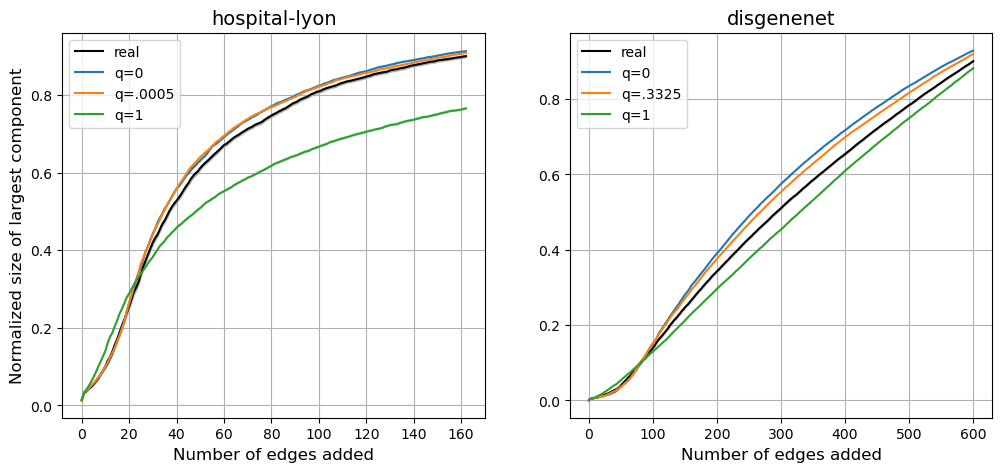

In [9]:
## plot#1 - random growth experiment
plt.figure(figsize=(12,5))
SE = np.sqrt(rolls['random growth']) ## 1 for actual SD

names = [
#    "contact-primary-school", 
#    "contact-high-school", 
    "hospital-lyon", 
#    "email-enron", 
#    "email-eu", 
#    "diseasome", 
    "disgenenet", 
#    "ndc-substances", 
#    "congress-bills", 
#    "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(1,2,ctr+1)

    n = int(df['n'][dataset]) ## number of nodes
    stop_value = 0.9*n
    c = 0
    while True:
        if df['random growth mean'][dataset][c] < stop_value:
            c += 1
        else:
            break
    cutoff = c+1
    
    _m = df['random growth mean'][dataset]
    _s = df['random growth stdv'][dataset]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='real', color='black')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2, color='black'
                    )

    _m = df['random growth mean'][dataset+' (q=0)']
    _s = df['random growth stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=0')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['random growth mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['random growth mean'][best]
    _s = df['random growth stdv'][best]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )

    _m = df['random growth mean'][dataset+' (q=1)']
    _s = df['random growth stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=1')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=0:
        plt.xlabel('Number of edges added', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Normalized size of largest component', fontsize=12)
    plt.grid()
    plt.legend();


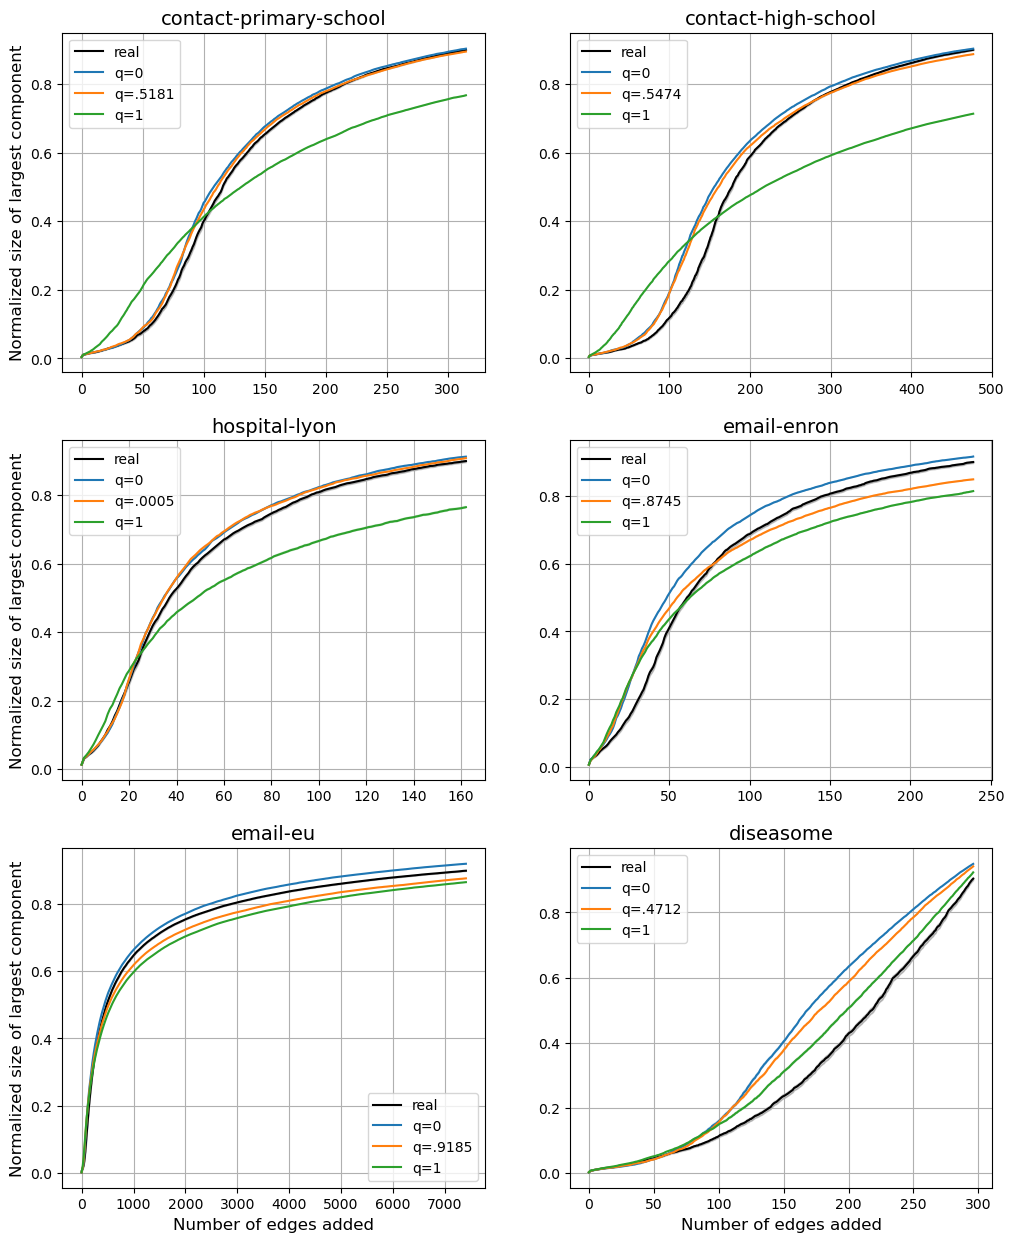

In [10]:
## plot#2 - random growth experiment
plt.figure(figsize=(12,15))
SE = np.sqrt(rolls['random growth']) ## 1 for actual SD

names = [
    "contact-primary-school", 
    "contact-high-school", 
    "hospital-lyon", 
    "email-enron", 
    "email-eu", 
    "diseasome", 
#    "disgenenet", 
#    "ndc-substances", 
#    "congress-bills", 
#    "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(3,2,ctr+1)

    n = int(df['n'][dataset]) ## number of nodes
    stop_value = 0.9*n
    c = 0
    while True:
        if df['random growth mean'][dataset][c] < stop_value:
            c += 1
        else:
            break
    cutoff = c+1
    
    _m = df['random growth mean'][dataset]
    _s = df['random growth stdv'][dataset]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='real', color='black')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2, color='black'
                    )

    _m = df['random growth mean'][dataset+' (q=0)']
    _s = df['random growth stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=0')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['random growth mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['random growth mean'][best]
    _s = df['random growth stdv'][best]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )

    _m = df['random growth mean'][dataset+' (q=1)']
    _s = df['random growth stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=1')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=4:
        plt.xlabel('Number of edges added', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Normalized size of largest component', fontsize=12)
    plt.grid()
    plt.legend();


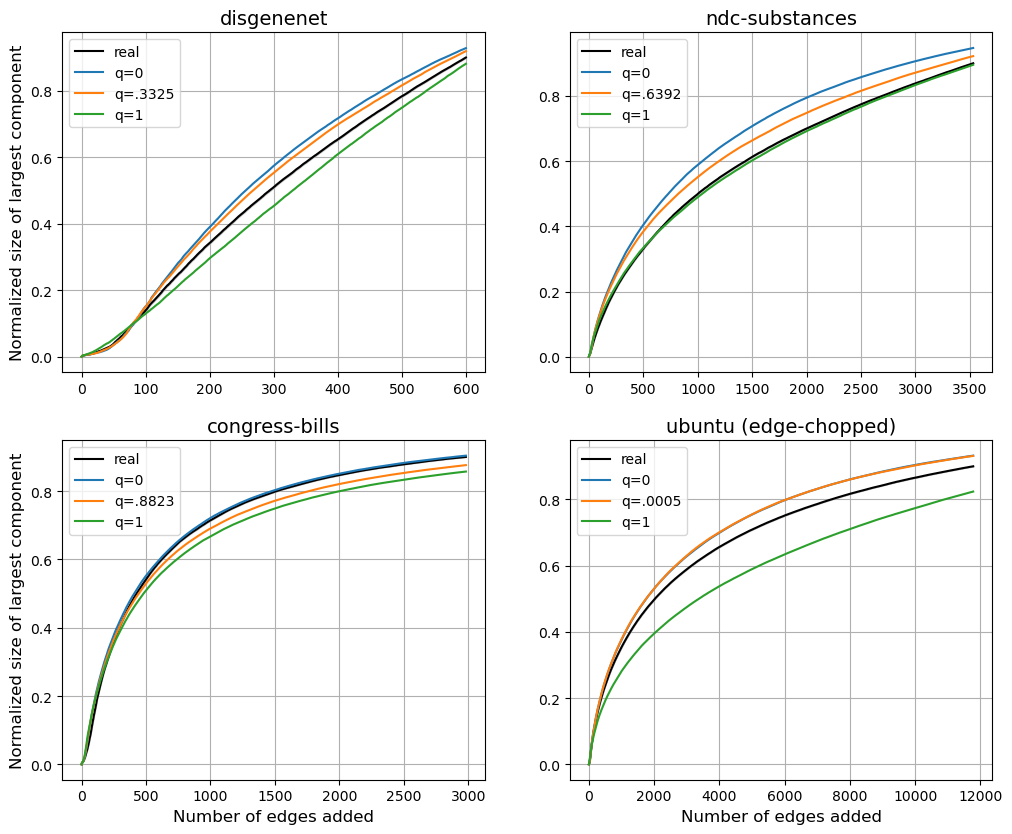

In [11]:
## plot#3 - random growth experiment
plt.figure(figsize=(12,15))
SE = np.sqrt(rolls['random growth']) ## 1 for actual SD

names = [
#     "contact-primary-school", 
#     "contact-high-school", 
#     "hospital-lyon", 
#     "email-enron", 
#     "email-eu", 
#     "diseasome", 
   "disgenenet", 
   "ndc-substances", 
   "congress-bills", 
   "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(3,2,ctr+1)

    n = int(df['n'][dataset]) ## number of nodes
    stop_value = 0.9*n
    c = 0
    while True:
        if df['random growth mean'][dataset][c] < stop_value:
            c += 1
        else:
            break
    cutoff = c+1
    
    _m = df['random growth mean'][dataset]
    _s = df['random growth stdv'][dataset]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='real', color='black')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2, color='black'
                    )

    _m = df['random growth mean'][dataset+' (q=0)']
    _s = df['random growth stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=0')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['random growth mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['random growth mean'][best]
    _s = df['random growth stdv'][best]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )

    _m = df['random growth mean'][dataset+' (q=1)']
    _s = df['random growth stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=1')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=2:
        plt.xlabel('Number of edges added', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Normalized size of largest component', fontsize=12)
    plt.grid()
    plt.legend();


# Experiment 2: adversarial growth
From the input graph, we compute the betweenness value of each edge

We start at round 0 with no edges and a max component size of 1

At round i+1, we pick the edge with smallest betweenness from the set of edges not chosen yet and add it to the graph, tracking the size of the giant

We save the data as the dictionary (round -> size of giant)

In [31]:
## either load results so far or initialize
#df = pd.DataFrame({'n': vertex_data.copy(), 'm': edge_data.copy()})

with open('adversarial_growth_experiments.pkl','rb') as file:
    df = pkl.load(file)
    

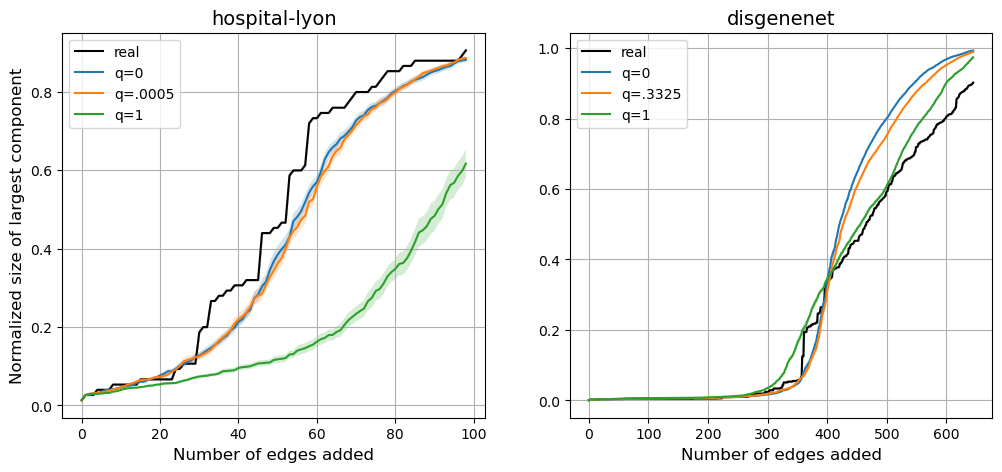

In [32]:
## plot#1 - adversarial growth experiment
plt.figure(figsize=(12,5))
SE = np.sqrt(rolls['adversarial growth']) ## 1 for actual SD

names = [
#    "contact-primary-school", 
#    "contact-high-school", 
    "hospital-lyon", 
#    "email-enron", 
#    "email-eu", 
#    "diseasome", 
    "disgenenet", 
#    "ndc-substances", 
#    "congress-bills", 
#    "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(1,2,ctr+1)

    n = int(df['n'][dataset]) ## number of nodes
    stop_value = 0.9*n
    c = 0
    while True:
        if df['adversarial growth mean'][dataset][c] < stop_value:
            c += 1
        else:
            break
    cutoff = c+1
    
    _m = df['adversarial growth mean'][dataset]
    _s = df['adversarial growth stdv'][dataset]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='real', color='black')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2, color='black'
                    )

    _m = df['adversarial growth mean'][dataset+' (q=0)']
    _s = df['adversarial growth stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=0')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['adversarial growth mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['adversarial growth mean'][best]
    _s = df['adversarial growth stdv'][best]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )

    _m = df['adversarial growth mean'][dataset+' (q=1)']
    _s = df['adversarial growth stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=1')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=0:
        plt.xlabel('Number of edges added', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Normalized size of largest component', fontsize=12)
    plt.grid()
    plt.legend();


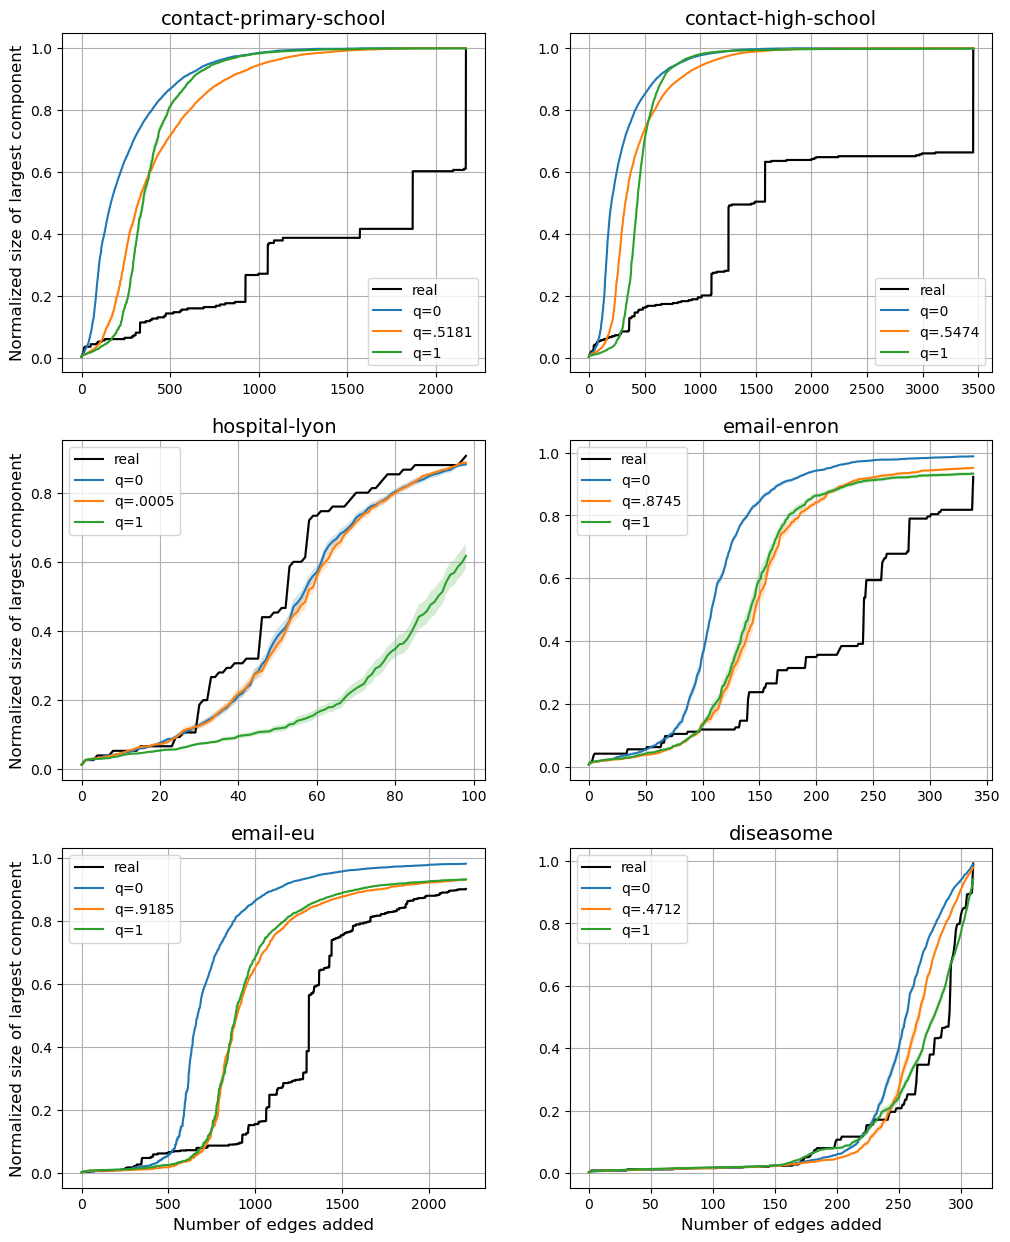

In [33]:
## plot#2 - adversarial growth experiment
plt.figure(figsize=(12,15))
SE = np.sqrt(rolls['adversarial growth']) ## 1 for actual SD

names = [
    "contact-primary-school", 
    "contact-high-school", 
    "hospital-lyon", 
    "email-enron", 
    "email-eu", 
    "diseasome", 
#    "disgenenet", 
#    "ndc-substances", 
#    "congress-bills", 
#    "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(3,2,ctr+1)

    n = int(df['n'][dataset]) ## number of nodes
    stop_value = 0.9*n
    c = 0
    while True:
        if df['adversarial growth mean'][dataset][c] < stop_value:
            c += 1
        else:
            break
    cutoff = c+1
    
    _m = df['adversarial growth mean'][dataset]
    _s = df['adversarial growth stdv'][dataset]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='real', color='black')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2, color='black'
                    )

    _m = df['adversarial growth mean'][dataset+' (q=0)']
    _s = df['adversarial growth stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=0')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['adversarial growth mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['adversarial growth mean'][best]
    _s = df['adversarial growth stdv'][best]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )

    _m = df['adversarial growth mean'][dataset+' (q=1)']
    _s = df['adversarial growth stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=1')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=4:
        plt.xlabel('Number of edges added', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Normalized size of largest component', fontsize=12)
    plt.grid()
    plt.legend();


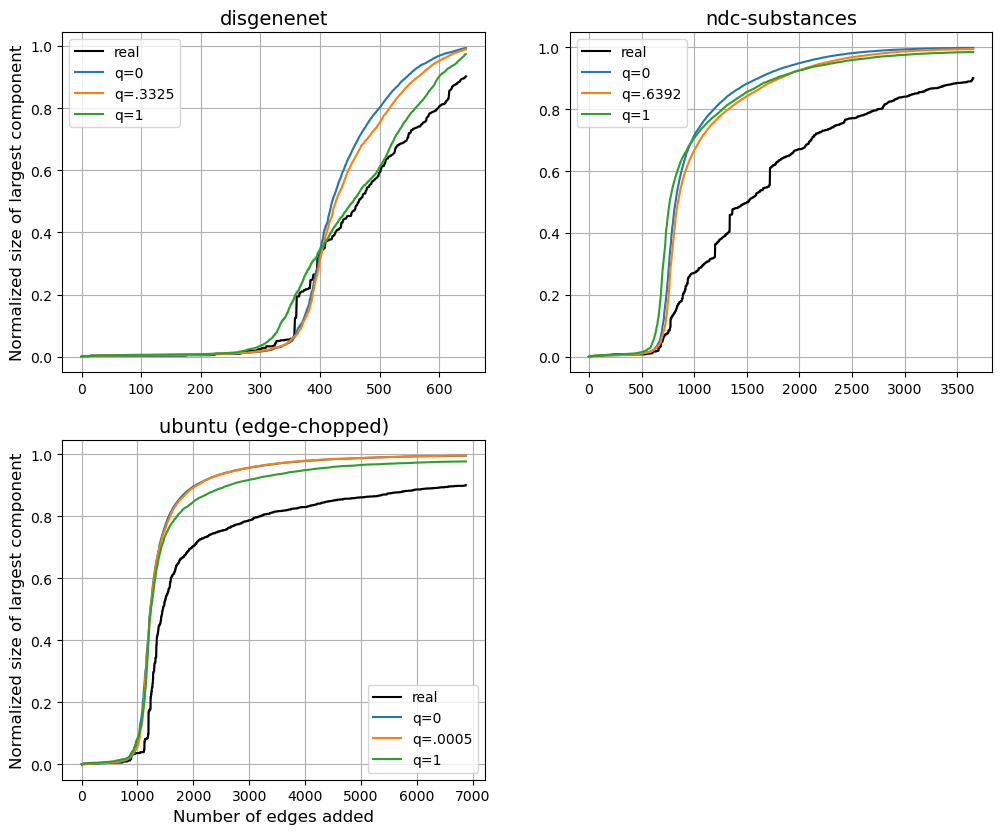

In [34]:
## plot#3 - adversarial growth experiment
plt.figure(figsize=(12,15))
SE = np.sqrt(rolls['adversarial growth']) ## 1 for actual SD

names = [
#     "contact-primary-school", 
#     "contact-high-school", 
#     "hospital-lyon", 
#     "email-enron", 
#     "email-eu", 
#     "diseasome", 
   "disgenenet", 
   "ndc-substances", 
#   "congress-bills", 
   "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(3,2,ctr+1)

    n = int(df['n'][dataset]) ## number of nodes
    stop_value = 0.9*n
    c = 0
    while True:
        if df['adversarial growth mean'][dataset][c] < stop_value:
            c += 1
        else:
            break
    cutoff = c+1
    
    _m = df['adversarial growth mean'][dataset]
    _s = df['adversarial growth stdv'][dataset]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='real', color='black')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2, color='black'
                    )

    _m = df['adversarial growth mean'][dataset+' (q=0)']
    _s = df['adversarial growth stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=0')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['adversarial growth mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['adversarial growth mean'][best]
    _s = df['adversarial growth stdv'][best]
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )

    _m = df['adversarial growth mean'][dataset+' (q=1)']
    _s = df['adversarial growth stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=1')
    plt.fill_between(list(_m.keys())[:cutoff], 
                     np.array([i/n for i in _m.values()][:cutoff])-np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     np.array([i/n for i in _m.values()][:cutoff])+np.array([(i/n)/SE for i in _s.values()][:cutoff]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=2:
        plt.xlabel('Number of edges added', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Normalized size of largest component', fontsize=12)
    plt.grid()
    plt.legend();


# Experiment 3: Single-source diffusion
We start with a weight function with w(v) = 0 for all but one vertex; a random vertex gets w(v) = 1

Each round, we pick an edge and replace the vertex weights by the average

We save the dictionary (round -> wasserstein distance between w and uniform)

The first time we run the experiment, we run until the distance is < 1/(20|V|) and we record the number of rounds this took

Then we run every other sample for the recorded number of rounds 

In [35]:
## either load results so far or initialize
#df = pd.DataFrame({'n': vertex_data.copy(), 'm': edge_data.copy()})

with open('single_source_diffusion_experiments.pkl','rb') as file:
    df = pkl.load(file)
    

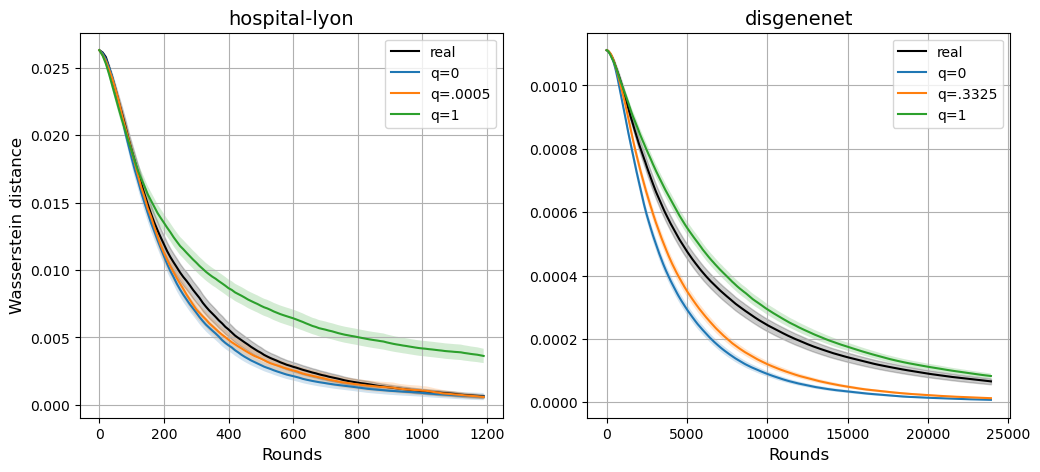

In [37]:
## plot#1 - single-source diffusion experiment
SE = np.sqrt(rolls['single-source diffusion']) ## 1 for SD

plt.figure(figsize=(12,5))
names = [
#    "contact-primary-school", 
#    "contact-high-school", 
    "hospital-lyon", 
#    "email-enron", 
#    "email-eu", 
#    "diseasome", 
    "disgenenet", 
#    "ndc-substances", 
#    "congress-bills", 
#    "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(1,2,ctr+1)
    
    _m = df['single-source diffusion mean'][dataset]
    _s = df['single-source diffusion stdv'][dataset]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='real', color='black')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2, color='black'
                    )

    _m = df['single-source diffusion mean'][dataset+' (q=0)']
    _s = df['single-source diffusion stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=0')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['single-source diffusion mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['single-source diffusion mean'][best]
    _s = df['single-source diffusion stdv'][best]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )

    _m = df['single-source diffusion mean'][dataset+' (q=1)']
    _s = df['single-source diffusion stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=1')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=0:
        plt.xlabel('Rounds', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Wasserstein distance', fontsize=12)
    plt.grid()
    plt.legend();


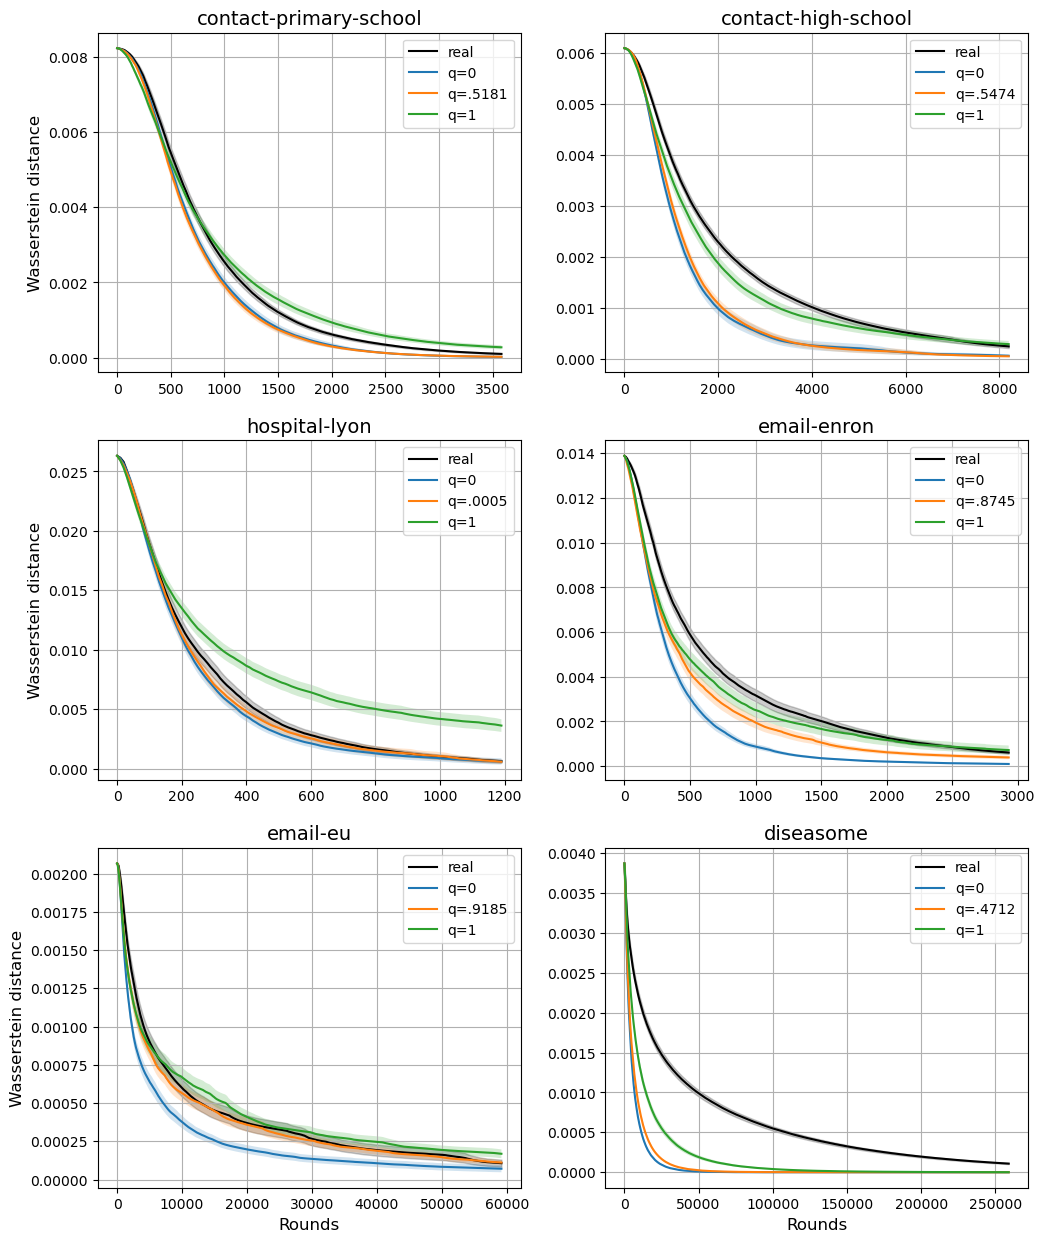

In [38]:
## plot#2 - single-source diffusion experiment
SE = np.sqrt(rolls['single-source diffusion']) ## 1 for SD

plt.figure(figsize=(12,15))
names = [
   "contact-primary-school", 
   "contact-high-school", 
   "hospital-lyon", 
   "email-enron", 
   "email-eu", 
   "diseasome", 
#    "disgenenet", 
#    "ndc-substances", 
#    "congress-bills", 
#    "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(3,2,ctr+1)
    
    _m = df['single-source diffusion mean'][dataset]
    _s = df['single-source diffusion stdv'][dataset]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='real', color='black')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2, color='black'
                    )

    _m = df['single-source diffusion mean'][dataset+' (q=0)']
    _s = df['single-source diffusion stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=0')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['single-source diffusion mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['single-source diffusion mean'][best]
    _s = df['single-source diffusion stdv'][best]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )

    _m = df['single-source diffusion mean'][dataset+' (q=1)']
    _s = df['single-source diffusion stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=1')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=4:
        plt.xlabel('Rounds', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Wasserstein distance', fontsize=12)
    plt.grid()
    plt.legend();


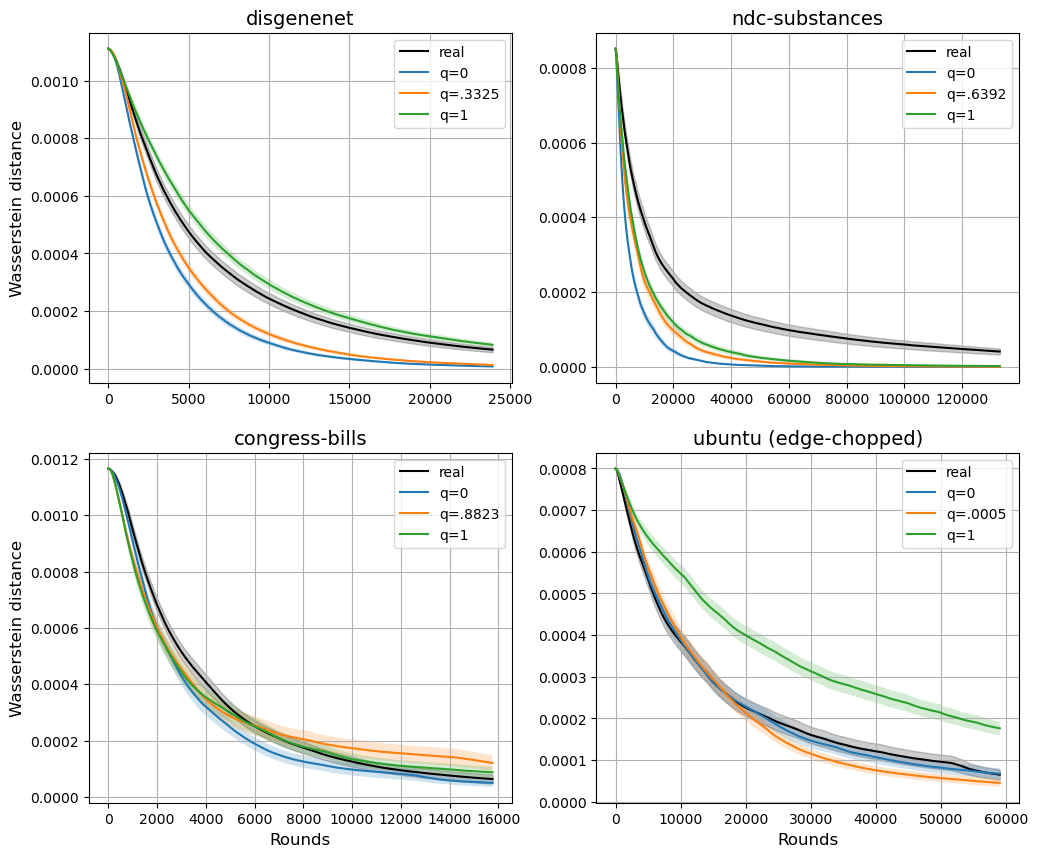

In [39]:
## plot#3 - single-source diffusion experiment
SE = np.sqrt(rolls['single-source diffusion']) ## 1 for SD

plt.figure(figsize=(12,10))
names = [
#    "contact-primary-school", 
#    "contact-high-school", 
#    "hospital-lyon", 
#    "email-enron", 
#    "email-eu", 
#    "diseasome", 
   "disgenenet", 
   "ndc-substances", 
   "congress-bills", 
   "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(2,2,ctr+1)
    
    _m = df['single-source diffusion mean'][dataset]
    _s = df['single-source diffusion stdv'][dataset]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='real', color='black')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2, color='black'
                    )

    _m = df['single-source diffusion mean'][dataset+' (q=0)']
    _s = df['single-source diffusion stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=0')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['single-source diffusion mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['single-source diffusion mean'][best]
    _s = df['single-source diffusion stdv'][best]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )

    _m = df['single-source diffusion mean'][dataset+' (q=1)']
    _s = df['single-source diffusion stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=1')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=2:
        plt.xlabel('Rounds', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Wasserstein distance', fontsize=12)
    plt.grid()
    plt.legend();


# Experiment 4: 10% sprinkled diffusion
Identical to experiment 3 but 10% of nodes start with w(v) = 1 and we stop when the distance is < 0.005

In both of these experiments, the idea is to reach 5% of the initial distance

In [40]:
## either load results so far or initialize
#df = pd.DataFrame({'n': vertex_data.copy(), 'm': edge_data.copy()})

with open('sprinkled_diffusion_experiments.pkl','rb') as file:
    df = pkl.load(file)


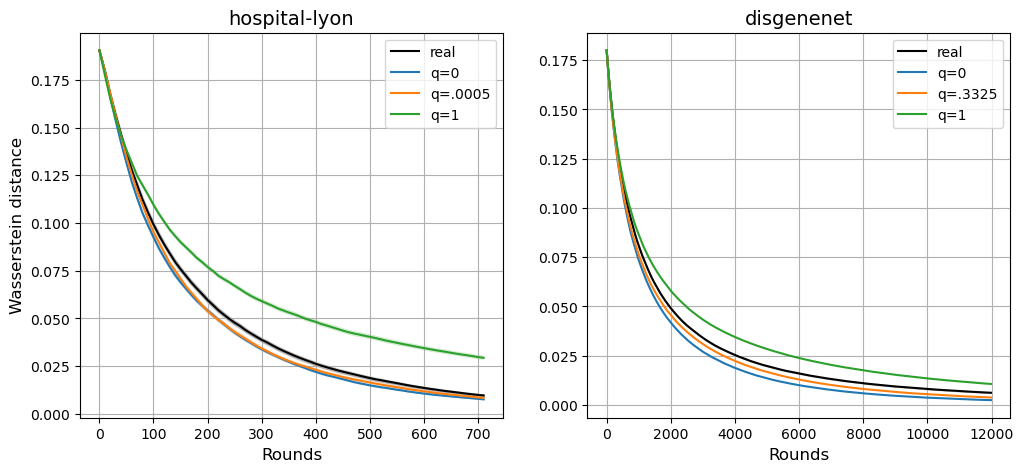

In [41]:
## plot#1 - 10% sprinkled diffusion experiment
SE = np.sqrt(rolls['10% sprinkled diffusion']) ## 1 for SD

plt.figure(figsize=(12,5))
names = [
#    "contact-primary-school", 
#    "contact-high-school", 
    "hospital-lyon", 
#    "email-enron", 
#    "email-eu", 
#    "diseasome", 
    "disgenenet", 
#    "ndc-substances", 
#    "congress-bills", 
#    "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(1,2,ctr+1)
    
    _m = df['10% sprinkled diffusion mean'][dataset]
    _s = df['10% sprinkled diffusion stdv'][dataset]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='real', color='black')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2, color='black'
                    )

    _m = df['10% sprinkled diffusion mean'][dataset+' (q=0)']
    _s = df['10% sprinkled diffusion stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=0')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['10% sprinkled diffusion mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['10% sprinkled diffusion mean'][best]
    _s = df['10% sprinkled diffusion stdv'][best]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )

    _m = df['10% sprinkled diffusion mean'][dataset+' (q=1)']
    _s = df['10% sprinkled diffusion stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=1')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=0:
        plt.xlabel('Rounds', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Wasserstein distance', fontsize=12)
    plt.grid()
    plt.legend();


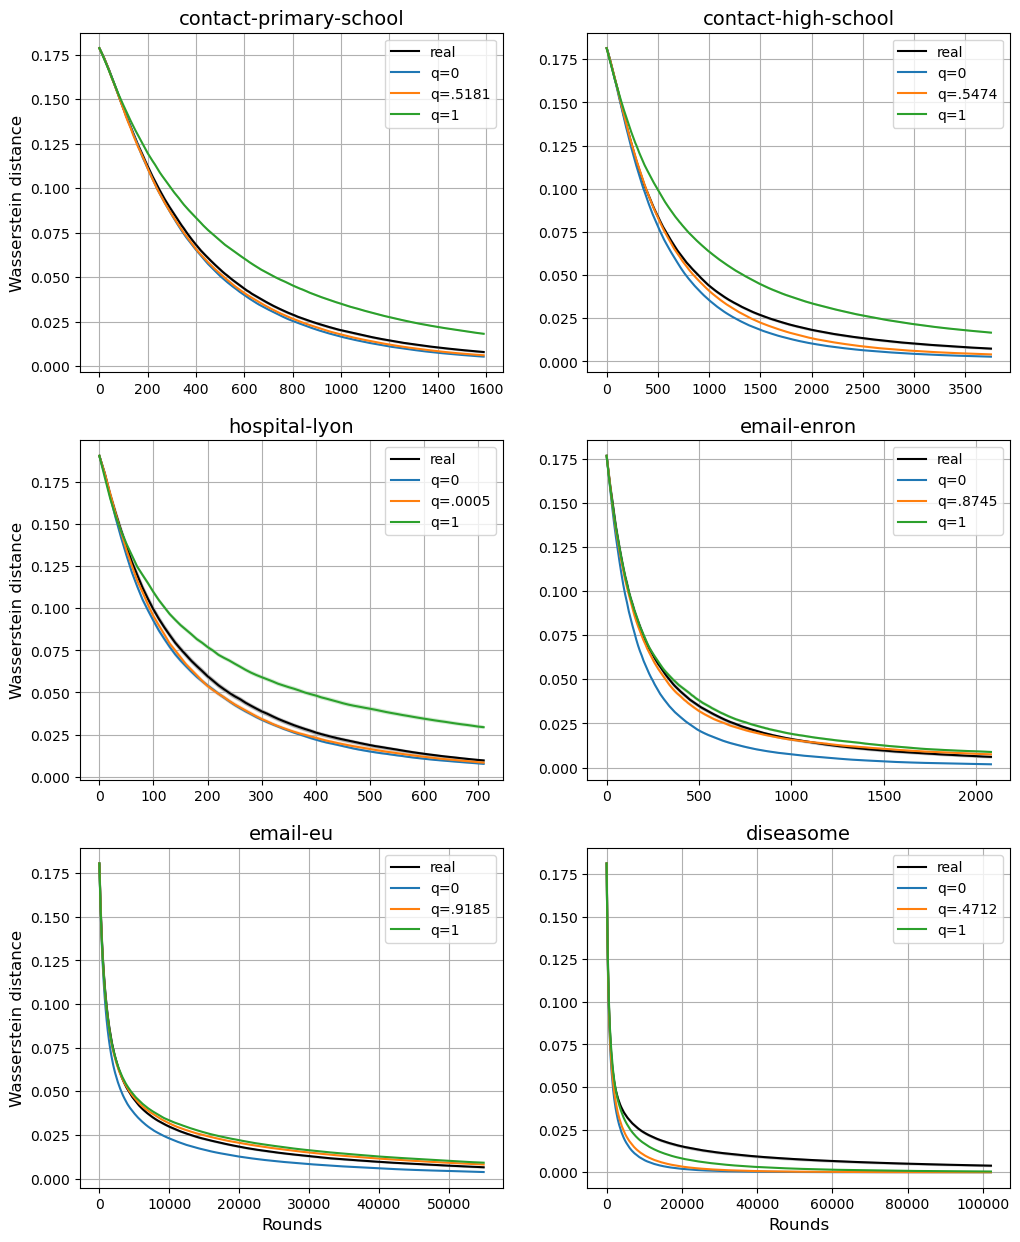

In [42]:
## plot#2 - 10% sprinkled diffusion experiment
SE = np.sqrt(rolls['10% sprinkled diffusion']) ## 1 for SD

plt.figure(figsize=(12,15))
names = [
    "contact-primary-school", 
    "contact-high-school", 
    "hospital-lyon", 
    "email-enron", 
    "email-eu", 
    "diseasome", 
#    "disgenenet", 
#    "ndc-substances", 
#    "congress-bills", 
#    "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(3,2,ctr+1)
    
    _m = df['10% sprinkled diffusion mean'][dataset]
    _s = df['10% sprinkled diffusion stdv'][dataset]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='real', color='black')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2, color='black'
                    )

    _m = df['10% sprinkled diffusion mean'][dataset+' (q=0)']
    _s = df['10% sprinkled diffusion stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=0')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['10% sprinkled diffusion mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['10% sprinkled diffusion mean'][best]
    _s = df['10% sprinkled diffusion stdv'][best]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )

    _m = df['10% sprinkled diffusion mean'][dataset+' (q=1)']
    _s = df['10% sprinkled diffusion stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=1')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=4:
        plt.xlabel('Rounds', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Wasserstein distance', fontsize=12)
    plt.grid()
    plt.legend();


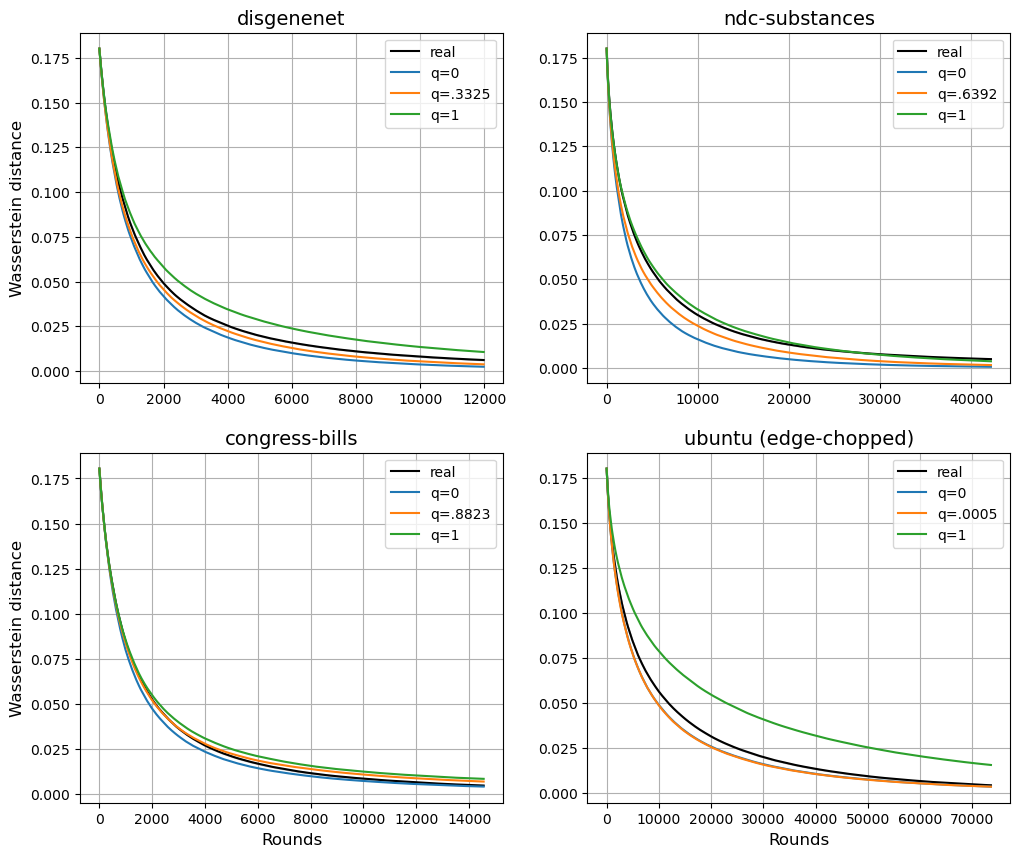

In [43]:
## plot#3 - 10% sprinkled diffusion experiment
SE = np.sqrt(rolls['10% sprinkled diffusion']) ## 1 for SD

plt.figure(figsize=(12,10))
names = [
#     "contact-primary-school", 
#     "contact-high-school", 
#     "hospital-lyon", 
#     "email-enron", 
#     "email-eu", 
#     "diseasome", 
   "disgenenet", 
   "ndc-substances", 
   "congress-bills", 
   "ubuntu (edge-chopped)",
]

for ctr, dataset in enumerate(names):

    plt.subplot(2,2,ctr+1)
    
    _m = df['10% sprinkled diffusion mean'][dataset]
    _s = df['10% sprinkled diffusion stdv'][dataset]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='real', color='black')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2, color='black'
                    )

    _m = df['10% sprinkled diffusion mean'][dataset+' (q=0)']
    _s = df['10% sprinkled diffusion stdv'][dataset+' (q=0)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=0')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    ## best case
    best = [x for x in df['10% sprinkled diffusion mean'].keys() if 'q=0.' in x and dataset in x][0]
    _m = df['10% sprinkled diffusion mean'][best]
    _s = df['10% sprinkled diffusion stdv'][best]
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q='+best.split('=')[1][1:-1])
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )

    _m = df['10% sprinkled diffusion mean'][dataset+' (q=1)']
    _s = df['10% sprinkled diffusion stdv'][dataset+' (q=1)']
    plt.plot(list(_m.keys()), [i for i in _m.values()], label='q=1')
    plt.fill_between(list(_m.keys()), 
                     np.array([i for i in _m.values()])-np.array([i/SE for i in _s.values()]),
                     np.array([i for i in _m.values()])+np.array([i/SE for i in _s.values()]),
                     alpha=.2
                    )
    plt.title(dataset, fontsize=14)
    if ctr>=2:
        plt.xlabel('Rounds', fontsize=12)
    if ctr%2 == 0:
        plt.ylabel('Wasserstein distance', fontsize=12)
    plt.grid()
    plt.legend();
